Aim: To answer the question as to why my new approach is working worse than the old approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from tqdm import tqdm
import scipy

/home/james/Repo/PhD Repo/time_series_clustering/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time_series.time_series_models import KernelRidgeRegression, RascuttiModel
from time_series.data_generators import LorenzGenerator
from time_series.kernels import GaussianKernel
from time_series.evaluators import MeanSquaredError

2025-10-10 16:55:53.934 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [3]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [4]:
from time_series.data_handlers import TimeSeriesData

In [5]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
noise_cov = 0
dt = 1e-2
T = 5

dynamics = [
    dict(rho=14, sigma=10, beta=8/3),
    dict(rho=28, sigma=10, beta=8/3),
    dict(rho=28, sigma=1, beta=8/3)
]

starting_points = [
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 2],
    [2, 1, 1],
    [-1,-1,1]
]

datasets = []
labels = []
for di, d in enumerate(dynamics):
    for s in starting_points:
        _, data = LorenzGenerator(noise_mean=[0,0,0], noise_covariance=noise_cov, dt=dt, T=T, x0=s, **d)()
        datasets.append(
            TimeSeriesData(
                X = data[:-1],
                y = data[1:],
                train_val_test_split=[0.5, 0.3, 0.2],
                labels = [f"X_{di}", f"Y_{di}", f"Z_{di}"],
                dataset_label = di,
                parameters=d   
            )
        )

        print(f"x0: {s}, dynamics: {d}\n")

x0: [1, 1, 1], dynamics: {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 2, 1], dynamics: {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 1, 2], dynamics: {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [2, 1, 1], dynamics: {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [-1, -1, 1], dynamics: {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 1, 1], dynamics: {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 2, 1], dynamics: {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 1, 2], dynamics: {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [2, 1, 1], dynamics: {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [-1, -1, 1], dynamics: {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}

x0: [1, 1, 1], dynamics: {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}

x0: [1, 2, 1], dynamics: {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}

x0: [1, 1, 2], dynamics: {'rho': 28, 'sigma': 1, '

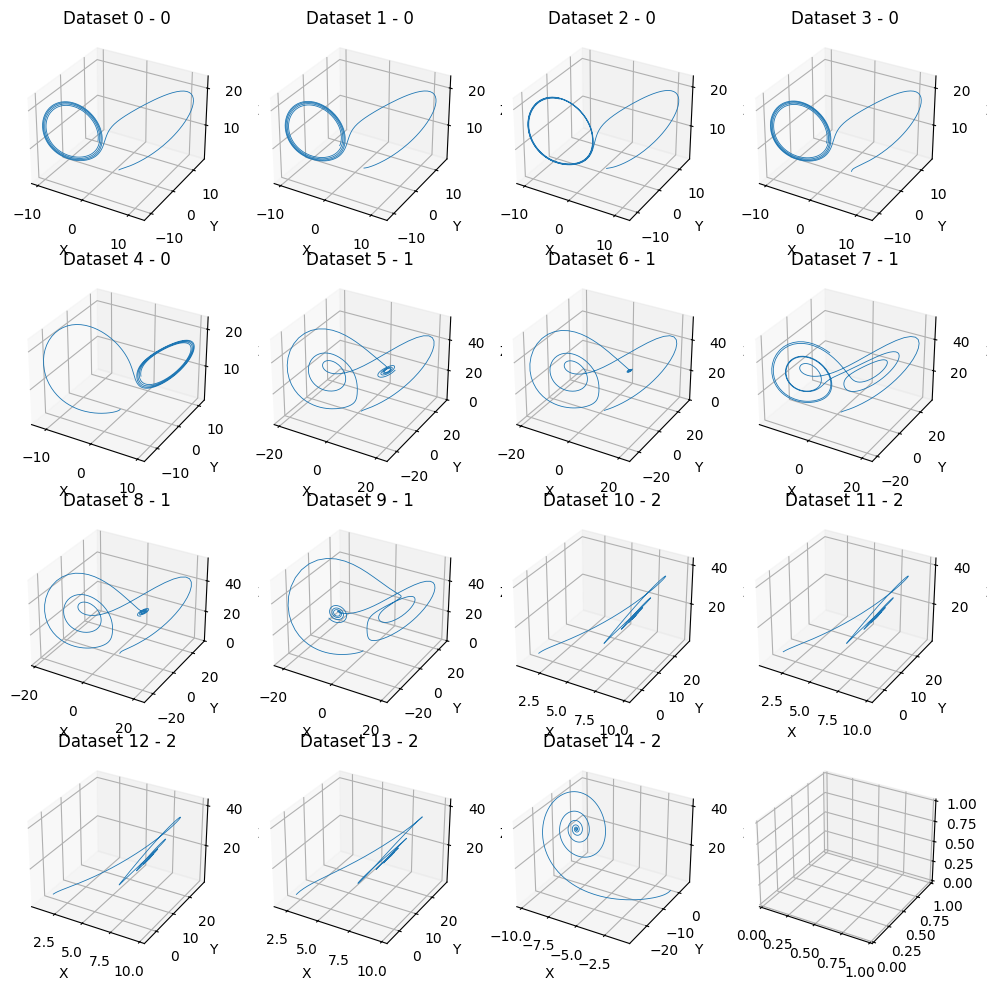

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=int(np.ceil(len(datasets)/4)), figsize=(12, 12), subplot_kw={'projection': '3d'})

titles = [f"Dataset {i} - {datasets[i].dataset_label}" for i in range(len(datasets))]
for i, [ax_, title] in enumerate(zip(ax.flat, titles)):
    ax_.plot(*datasets[i].X[:, 0:3].T, lw=0.6)
    ax_.set_title(title)
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")
    ax_.set_zlabel("Z")


# Old approach

In [8]:
models = []
evaluator = MeanSquaredError()
metrics_old = []

for dataset in tqdm(datasets):
    X_train, y_train = dataset.train_data()
    X_test, y_test = dataset.test_data()
    X_val, y_val = dataset.val_data()

    # Fit model
    kernels=[
            GaussianKernel(bandwidth=70) for i in range(dataset.X.shape[1])
        ]

    krr_model = KernelRidgeRegression(
        kernels=kernels,
        reg = 1e-8
    )

    X_train_all = np.concatenate([X_train, X_val], axis=0)
    y_train_all = np.concatenate([y_train, y_val], axis=0)

    krr_model.fit(X_train_all, y_train_all)

    models.append(krr_model)

    y_pred = krr_model.predict(X_test)
    metrics_old.append(evaluator(y_test, y_pred))

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


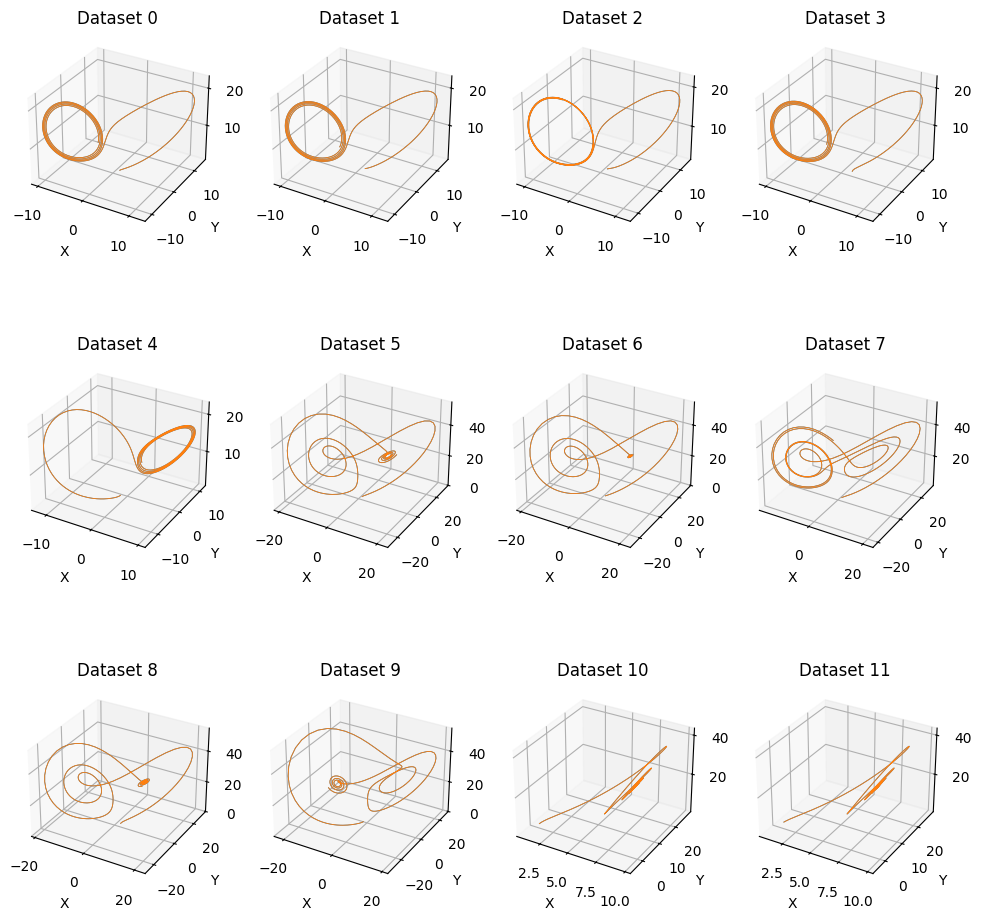

In [9]:
# Plot predictions as sanity check

fig, ax = plt.subplots(ncols=4, nrows=int(len(datasets)/4), figsize=(12, 12), subplot_kw={'projection': '3d'})

titles = [f"Dataset {i}" for i in range(len(datasets))]
for i, [ax_, title] in enumerate(zip(ax.flat, titles)):
    X, y = datasets[i].X, datasets[i].y
    y_pred = models[i].predict(X)
    ax_.plot(*y[:, 0:3].T, lw=0.6)
    ax_.plot(*y_pred[:, 0:3].T, lw=0.6)
    ax_.set_title(title)
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")
    ax_.set_zlabel("Z")

In [10]:
inner_product_matrix = np.zeros(shape=(len(datasets), len(datasets)))

kernel_common = GaussianKernel(bandwidth=70)

for di in tqdm(range(len(datasets))):
    for dj in range(di, len(datasets)):
        model1 = models[di]
        model2 = models[dj]

        ds1_xt, _ = datasets[di].train_data()
        ds1_xv, _ = datasets[di].val_data()
        ds1_x = np.concatenate([ds1_xt, ds1_xv], axis=0)
        ds1_x, _ = model1.reshape_data(ds1_x)

        ds2_xt, _ = datasets[dj].train_data()
        ds2_xv, _ = datasets[dj].val_data()
        ds2_x = np.concatenate([ds2_xt, ds2_xv], axis=0)
        ds2_x, _ = model2.reshape_data(ds2_x)

        # model1_kernels = model1.kernels
        # model2_kernels = model2.kernels

        # model1_bandwidths = [model1_kernels[i].bandwidth for i in range(3)]
        # model2_bandwidths = [model2_kernels[i].bandwidth for i in range(3)]

        model1_alphas = model1.alpha#.reshape(3, -1).T
        model2_alphas = model2.alpha#.reshape(3, -1).T

        inner_product_total = 0

        kernels = []

        for dim in range(3):
            Kc = kernel_common(
                x1 = ds1_x,
                x2 = ds2_x
            )

            kernels.append(Kc)

        Kc = scipy.linalg.block_diag(*kernels)

        inner_product_matrix[di, dj] = (model1_alphas.T@Kc@model2_alphas)[0][0]
        inner_product_matrix[dj, di] = inner_product_matrix[di, dj]

100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


In [11]:
distance_matrix = np.zeros_like(inner_product_matrix)
for i in range(inner_product_matrix.shape[0]):
    for j in range(inner_product_matrix.shape[1]):
        distance_matrix[i, j] = inner_product_matrix[i, i] + inner_product_matrix[j, j] - 2*inner_product_matrix[i, j] 

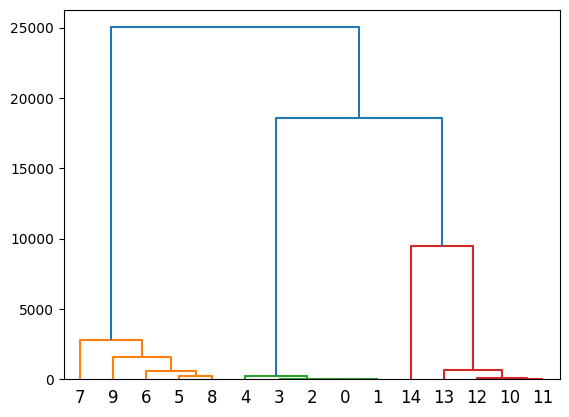

In [12]:
# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
plt.figure()
dendrogram(Z)
plt.show()

In [13]:
# Get cluster labels
labels = fcluster(Z, t=3, criterion='maxclust')  # t is number of clusters
cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].dataset_label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

2: [0, 0, 0, 0, 0]
1: [1, 1, 1, 1, 1]
3: [2, 2, 2, 2, 2]


# New approach

In [38]:
def tune_parameters(X_train, y_train, X_val, y_val, evaluator = None):
    if not evaluator:
        evaluator = MeanSquaredError()
        
    def objective(trial):
        kernels = [
            GaussianKernel(bandwidth=trial.suggest_float(f"bandwidth_{i}",50, 100))
            for i in range(X_train.shape[1])
        ]

        krr_model = KernelRidgeRegression(
            kernels=kernels,
            reg = 1e-8#trial.suggest_float("reg", 1e-11, 1e-6)
        )

        krr_model.fit(X_train, y_train)
        y_pred = krr_model.predict(X_val)

        return evaluator(y_val, y_pred)

    study = optuna.create_study()
    study.optimize(
        objective,
        n_trials=50,
        timeout=20*60
    )

    best_params = study.best_params

    return best_params

In [39]:
models = []
evaluator = MeanSquaredError()
metrics_new = []

for dataset in tqdm(datasets):
    X_train, y_train = dataset.train_data()
    X_test, y_test = dataset.test_data()
    X_val, y_val = dataset.val_data()

    # Run parameter tuning
    best_params = tune_parameters(X_train, y_train, X_val, y_val, evaluator)

    # Fit model
    kernels=[
            GaussianKernel(best_params[f"bandwidth_{i}"]) for i in range(dataset.X.shape[1])
            # GaussianKernel(bandwidth=70) for i in range(dataset.X.shape[1])
        ]

    krr_model = KernelRidgeRegression(
        kernels=kernels,
        reg = 1e-8#best_params["reg"]
    )

    X_train_all = np.concatenate([X_train, X_val], axis=0)
    y_train_all = np.concatenate([y_train, y_val], axis=0)

    krr_model.fit(X_train_all, y_train_all)

    models.append(krr_model)

    y_pred = krr_model.predict(X_test)

    metrics_new.append(evaluator(y_test, y_pred))

100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


In [40]:
df = pd.DataFrame()
df["Old"] = metrics_old
df["New"] = metrics_new

df["diff"] = df["New"] - df["Old"]

df

,Old,New,diff
0,4.225790e-05,2.023079e-05,-2.202711e-05
1,4.261985e-05,2.115416e-05,-2.146569e-05
2,7.161938e-06,7.105155e-06,-5.678328e-08
3,4.208141e-05,2.459278e-05,-1.748863e-05
4,4.225790e-05,2.268195e-05,-1.957595e-05
5,1.033709e-04,1.647766e-04,6.140571e-05
6,4.134209e-05,5.972477e-05,1.838268e-05
7,9.157829e-05,1.344238e-04,4.284547e-05
8,1.024382e-04,1.039020e-04,1.463867e-06
9,1.033709e-04,1.766072e-04,7.323623e-05


In [41]:
# # Plot predictions as sanity check

# fig, ax = plt.subplots(ncols=4, nrows=int(len(datasets)/4), figsize=(12, 12), subplot_kw={'projection': '3d'})

# titles = [f"Dataset {i}" for i in range(len(datasets))]
# for i, [ax_, title] in enumerate(zip(ax.flat, titles)):
#     X, y = datasets[i].X, datasets[i].y
#     y_pred = models[i].predict(X)
#     ax_.plot(*y[:, 0:3].T, lw=0.6)
#     ax_.plot(*y_pred[:, 0:3].T, lw=0.6)
#     ax_.set_title(title)
#     ax_.set_xlabel("X")
#     ax_.set_ylabel("Y")
#     ax_.set_zlabel("Z")

In [42]:
inner_product_matrix = np.zeros(shape=(len(datasets), len(datasets)))

kernel_common = GaussianKernel(bandwidth=1)

for di in tqdm(range(len(datasets))):
    for dj in range(di, len(datasets)):
        model1 = models[di]
        model2 = models[dj]

        ds1_xt, _ = datasets[di].train_data()
        ds1_xv, _ = datasets[di].val_data()
        ds1_x = np.concatenate([ds1_xt, ds1_xv], axis=0)
        ds1_x, _ = model1.reshape_data(ds1_x)

        ds2_xt, _ = datasets[dj].train_data()
        ds2_xv, _ = datasets[dj].val_data()
        ds2_x = np.concatenate([ds2_xt, ds2_xv], axis=0)
        ds2_x, _ = model2.reshape_data(ds2_x)

        model1_kernels = model1.kernels
        model2_kernels = model2.kernels

        model1_bandwidths = [model1_kernels[i].bandwidth for i in range(3)]
        model2_bandwidths = [model2_kernels[i].bandwidth for i in range(3)]

        model1_alphas = model1.alpha#.reshape(3, -1).T
        model2_alphas = model2.alpha#.reshape(3, -1).T

        inner_product_total = 0

        kernels = []

        for dim in range(3):
            Kc = kernel_common(
                x1 = ds1_x/model1_bandwidths[dim],
                x2 = ds2_x/model2_bandwidths[dim]
            )

            kernels.append(Kc)

        Kc = scipy.linalg.block_diag(*kernels)

        inner_product_matrix[di, dj] = (model1_alphas.T@Kc@model2_alphas)[0][0]
        inner_product_matrix[dj, di] = inner_product_matrix[di, dj]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


In [43]:
distance_matrix = np.zeros_like(inner_product_matrix)
for i in range(inner_product_matrix.shape[0]):
    for j in range(inner_product_matrix.shape[1]):
        distance_matrix[i, j] = inner_product_matrix[i, i] + inner_product_matrix[j, j] - 2*inner_product_matrix[i, j] 

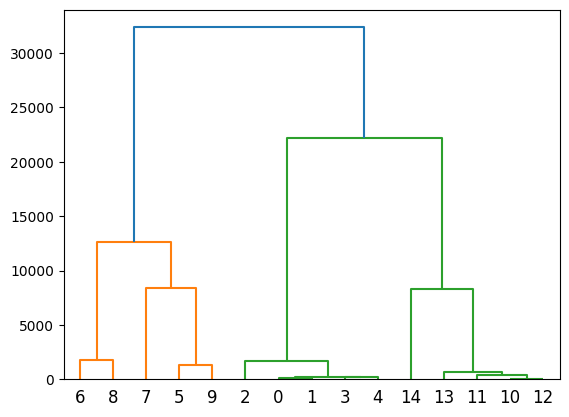

In [44]:
# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
plt.figure()
dendrogram(Z)
plt.show()

In [46]:
# Get cluster labels
labels = fcluster(Z, t=3, criterion='maxclust')  # t is number of clusters
cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].dataset_label for i in cluster_indices]

    print(f"Cluster {c}: {cluster_truth_labels}")

Cluster 2: [0, 0, 0, 0, 0]
Cluster 1: [1, 1, 1, 1, 1]
Cluster 3: [2, 2, 2, 2, 2]


In [56]:
datasets[cluster_indices[i]].X

array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.12      ,  0.98333333],
       [ 1.012     ,  1.23896667,  0.96831111],
       ...,
       [-2.10309323, -2.00243946, 10.09602558],
       [-2.09302785, -2.06451929,  9.8689114 ],
       [-2.09017699, -2.13033893,  9.64895139]], shape=(500, 3))

In [54]:
cluster_indices[i]

np.int64(0)

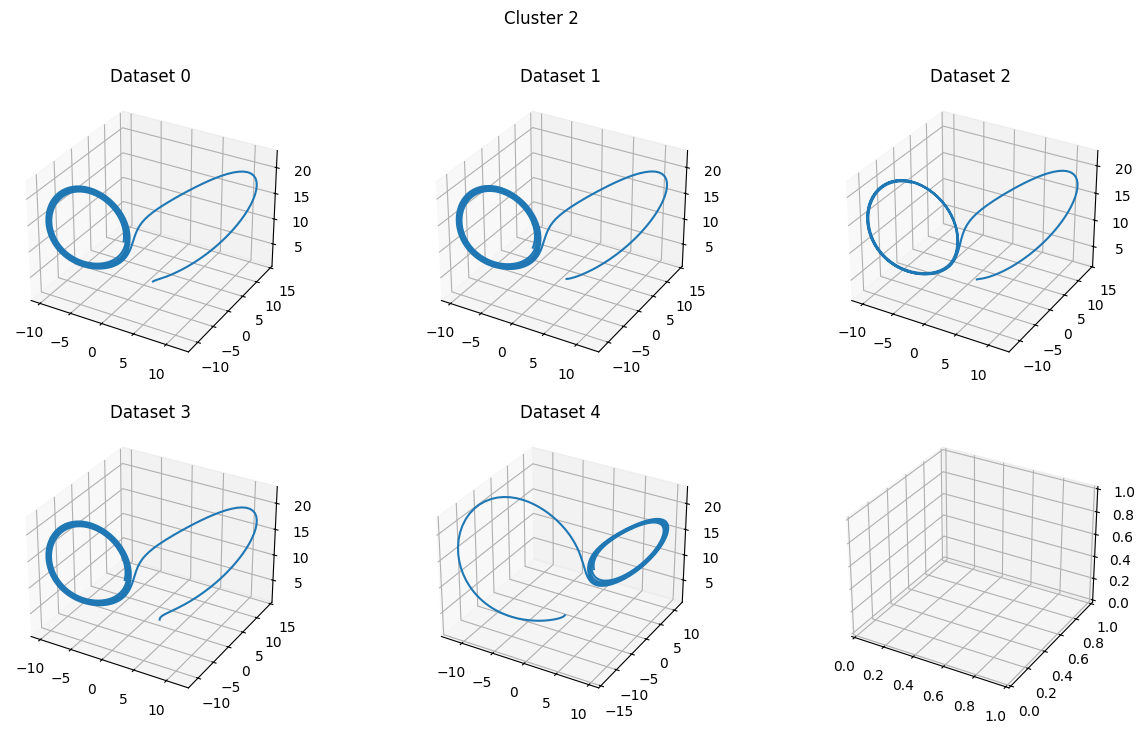

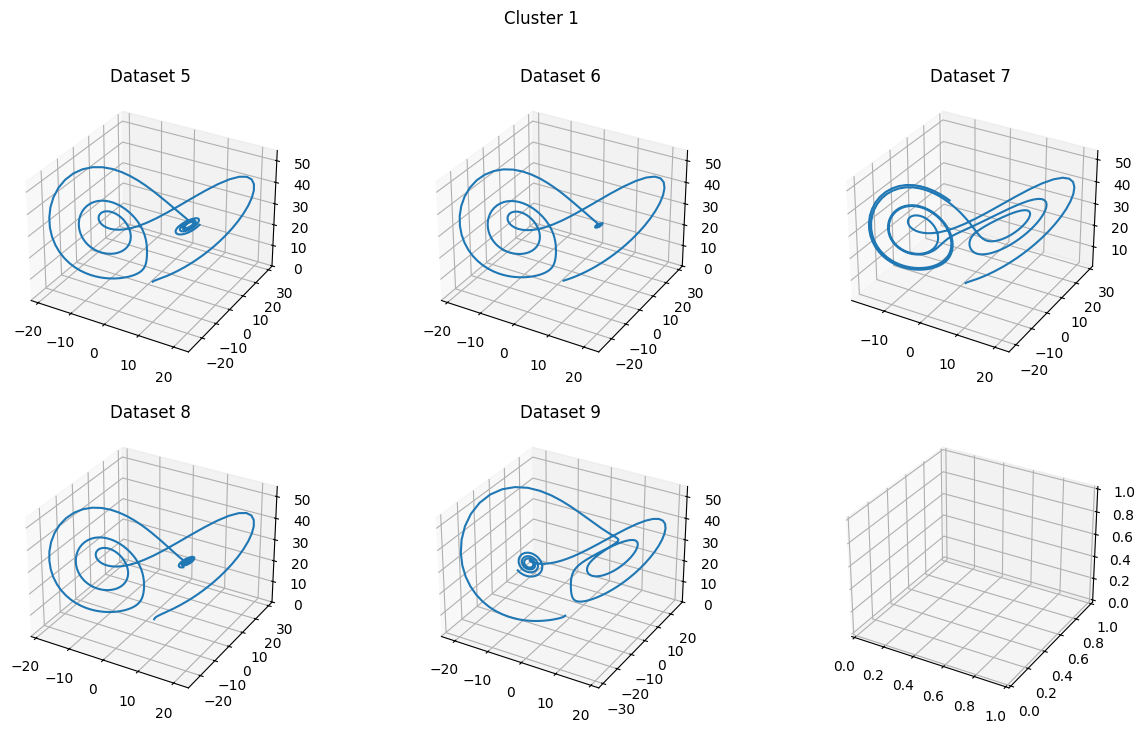

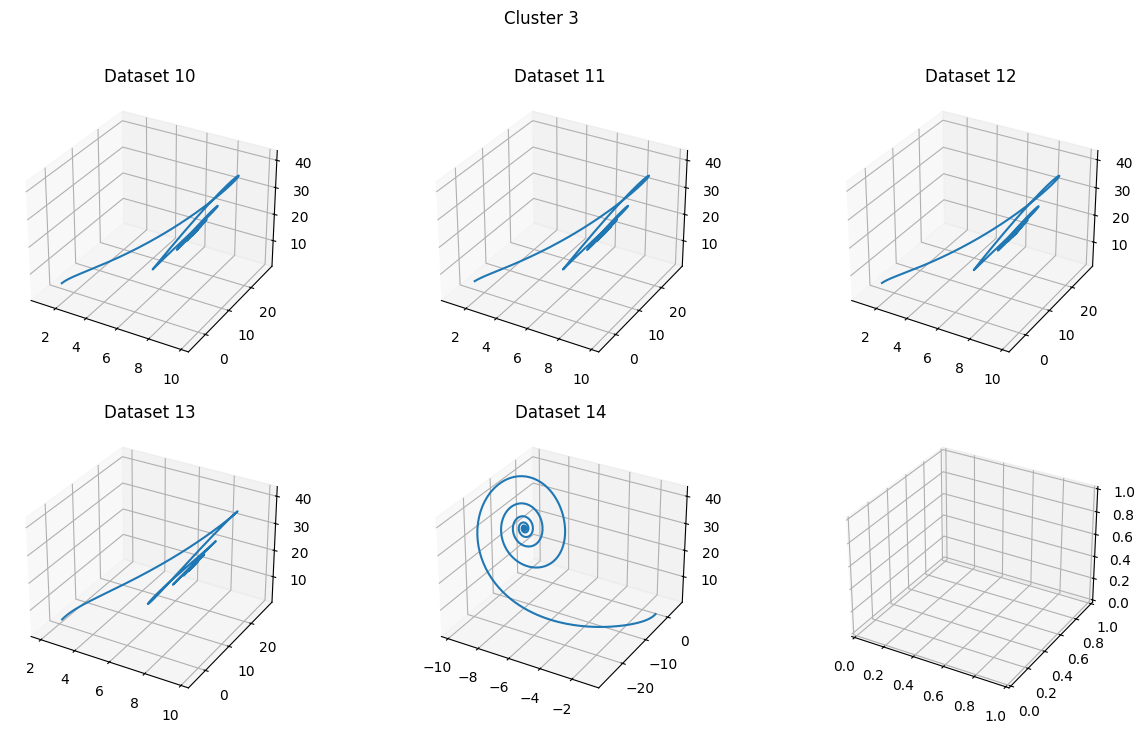

In [57]:
# empty_folder("cluster_plots")
for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index

    cluster_size = len(cluster_indices)

    nrows = int(np.ceil(cluster_size/3))
    ncols = min(len(cluster_indices), 3)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8), subplot_kw={'projection': '3d'})

    fig.suptitle(f"Cluster {c}")

    axes = ax.flat

    for i in range(len(cluster_indices)):
        axes[i].plot(*datasets[cluster_indices[i]].X.T)
        axes[i].set_title(f"Dataset {cluster_indices[i]}")

    # plt.savefig(f"cluster_plots/cluster_{c}.png")